### Program written by Pablo Sánchez-Palencia, 2022
Built-up on the basis of the code previously written by Scott Midgley

Scope: To train and test MLP model for band gap and mixing energy screening in the configurational space of Sn2GeN4 spinel solid solutions. 

In [1]:
### USER INPUT REQUIRED ###

# Windows path
repodir = r'C:\Users\pablo\OneDrive\Documentos\GitHub\GeSn2N4_ML'

#Define if the code is run in train (train the models from scratch) or load mode (load the pre-trained weights from the corresponding folder)
#mode="train"
mode="load"

# Define percentage of training data to use for training
#split = 20
#split = 50
split = 80

# Define the structural descriptor to use for training the model
#descriptor="Coulomb_mm"
#descriptor="Coulomb_ds"
#descriptor="Coulomb_corr"
#descriptor="Sine_mm"
#descriptor="Sine_ds"
#descriptor="Ewald_mm"
#descriptor="Ewald_ds"
#descriptor="MBTR"
descriptor="CorrM"

#Define property to predict with the model
#feature="SCF"
#feature="MixE";labelsname="Mixing Energy"
#feature="BGE";labelsname="Bandgap"
feature="HSE-corr";labelsname="Bandgap"

In [2]:
# Import modules.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam #Stochasic gradient descent method optimising weights and activations
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error,r2_score
import time
import pickle
import os
import shap

In [3]:
# Define MLP architecture.
def mlp_deep(dropout_rate=0.1):
    model = Sequential()
    model.add(Dense(256, input_dim=Xtrain[0].shape[0], activation='relu'))
    model.add(BatchNormalization())
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    return model

In [4]:
#Define generic functions to run ensembles
def train_model(model, index=99, epochs=10000, verbose=0, weights_dir='ensemble_weights/'):
    if not os.path.isdir(weights_dir):
        os.mkdir(weights_dir)
    start=time.time()
    ad = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)    
    #checkpoint = ModelCheckpoint(weights_dir + '/best_val_acc_%s.h5' % str(index),verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
    stopping =  EarlyStopping(monitor='val_mean_squared_error', patience=750, verbose=0, mode='auto', restore_best_weights=True)
    model.compile(loss='mean_squared_error', optimizer=ad, metrics=['mean_squared_error'])
    history = model.fit(Xtrain, ytrain, epochs=epochs, batch_size=32, verbose=verbose, validation_data=(Xval, yval), callbacks=[stopping])
    model.save(weights_dir + 'trainedmodel_'+feature+descriptor+str(index)+'.h5')
    end=time.time()
    print(f"Runtime of the program is {(end - start)/60} min")
    print(len(history.history['mean_squared_error']))
    return history 

def ensemble_inference(model, data, num_models=1,fileroot='ensemble_weights/trainedmodel_'):
    predictions = np.zeros(shape=(num_models, len(data),1))
    if num_models==1:
        model.load_weights(fileroot+feature+descriptor+str(99)+'.h5')
        predictions[0,:,:] = model.predict(data)
    else:
        for i in range(num_models):
            model.load_weights(fileroot+feature+descriptor+str(i)+'.h5')
            predictions[i,:,:] = model.predict(data)
    means = np.mean(predictions, axis=0)
    std = np.std(predictions, axis=0)
    return means, std, predictions

def score_model(realval,preds,print_results=False,graph=False,print_ingraph=False,savegraph=False):
    mae = mean_absolute_error(realval,preds)*1000
    maxerr= max(abs(preds.reshape(len(preds),)-realval))*1000
    r2=r2_score(realval,preds)
    if print_results==True:
        print('Mean absolute error {} meV'.format(mae))
        print('Maximum error {} meV'.format(maxerr))
        print('R2 = {}'.format(r2))
    if graph==True:
        if savegraph==True:
            plt.figure(dpi=600)
        else:
            plt.figure()
        plt.plot(realval.reshape(len(preds),),preds,'o')
        vmin=min(min(realval),min(preds));vmax=max(max(realval),max(preds))
        eje=np.linspace(vmin,vmax,10)
        plt.plot(eje,eje)
        plt.ylabel("Predicted values")
        plt.xlabel("Calculated values")
        plt.title("Bandgaps (eV)")
        ax=plt.gca()
        ax.set_xlim([vmin-0.01,vmax+0.01]);ax.set_ylim([vmin-0.01,vmax+0.01])
        ax.set_aspect('equal', adjustable='box')
        if print_ingraph==True:
            xtags=vmin+0.07*(vmax-vmin)
            yperc=np.array([0.9,0.85,0.8,0.75,0.7,0.65,0.6])
            ytags=vmin+yperc*(vmax-vmin)
            plt.text(xtags,ytags[0], "MAE = "+'%.2f' % (mae) +" meV")
            plt.text(xtags,ytags[1], r'$\epsilon$$_{max}$ = '+'%.2f' % (maxerr) +" meV")
            plt.text(xtags,ytags[2], r'R$^2$ = '+'%.3f' % r2)
        if savegraph==True:
            plt.savefig('MLP_'+descriptor+feature+".png")
        plt.show()
        plt.close()
    return mae,maxerr,r2

In [5]:
# Clear any existing Tensorflow data from cache.
clear_session()

## Load the data

In [6]:
# Import data and shuffle (optional).
ener = pd.read_pickle(repodir + '\\descriptors\\input_data_cm.pkl')
sm_data = pd.read_pickle(repodir + '\\descriptors\\input_data_sm.pkl')
em_data = pd.read_pickle(repodir + '\\descriptors\\input_data_em.pkl')
mbtr_data = pd.read_pickle(repodir + '\\descriptors\\input_data_mbtr.pkl')

ener["Sine_ds"]=sm_data["Sine_ds"]
ener["Sine_mm"]=sm_data["Sine_mm"]
ener["Ewald_ds"]=em_data["Ewald_ds"]
ener["Ewald_mm"]=em_data["Ewald_mm"]
ener["MBTR"]=mbtr_data["MBTR"]

ener = ener.sample(frac=1,random_state=91)

In [7]:
# Split data frame into training, validation, and testing data. 
l=len(ener)

e_test = ener.iloc[:l//10+1] #10% of data for testing model
e_val = ener.iloc[l//10+1:l//10*2+1] #10% of data for validation

if split == int(20):
    e_train = ener.iloc[l//10*2+1:l//10*4+1] #30% of data for training
elif split == int(50):
    e_train = ener.iloc[l//10*2+1:l//10*7+1] #50% of data for training
elif split == int(80):
    e_train = ener.iloc[l//10*2+1:l] #80% of data for training
else:
    print('Error: please choose a valid train/test split.')

In [8]:
# Print number of training data points
print('Number of training data points = ', len(e_train))
# Convert Pandas columns to Numpy arrays. Reshaping to obtain array of nested brackets. 
Xtrain = e_train[descriptor].to_numpy()
Xtrain = np.stack(Xtrain)
Xval   = e_val[descriptor].to_numpy()
Xval   = np.stack(Xval)
Xtest  = e_test[descriptor].to_numpy()
Xtest  = np.stack(Xtest)
ytrain = e_train[feature].to_numpy()
yval   = e_val[feature].to_numpy()
ytest  = e_test[feature].to_numpy()
itrain = e_train['tag'].to_numpy()
ival   = e_val['tag'].to_numpy()
itest  = e_test['tag'].to_numpy()

Number of training data points =  810


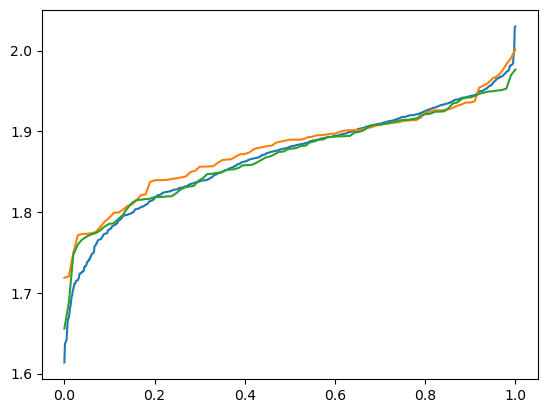

In [9]:
plt.figure()
plt.plot(np.linspace(0,1,len(ytrain)),sorted(ytrain))
plt.plot(np.linspace(0,1,len(yval)),sorted(yval))
plt.plot(np.linspace(0,1,len(ytest)),sorted(ytest))
plt.show()
plt.close()

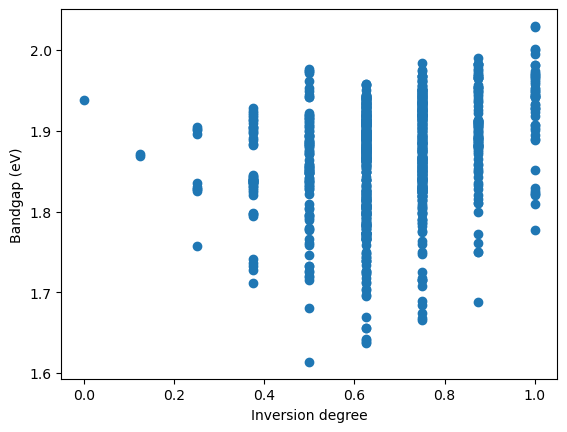

In [10]:
plt.figure()
plt.plot(ener['inv'],ener[feature],'o')
plt.xlabel("Inversion degree")
plt.ylabel(labelsname+" (eV)")
plt.show()
plt.close()

## Train a model from scrach 

You can retrain a new model on any amount of the data that you would like to use.
Note - the model will probably take around 8000 epochs to reach the stopping creteria prescribed below (these are the criteria used in the paper).

You can build either the shallow or the deep network using the `shallow_mlp` and `deep_mlp` functions respectively.

In [11]:
# Define MLP architecture. 
model = mlp_deep(dropout_rate=0.1)

In [12]:
# Summarize model trainable parameters. 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               8960      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

In [13]:
# Train MLP.
if mode=="train":
    history=train_model(model)

In [14]:
# Plote validation MAE vs number of training epochs. 
if mode=="train":
    plt.figure()
    print(history.history.keys())
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Training Epoch')
    plt.ylim(0,0.25)
    #print(history.history['val_mean_squared_error'][-1])
    #print(min(history.history['val_mean_squared_error']))
    plt.show()
    plt.close()

Mean absolute error 6.129753701680939 meV
Maximum error 28.52736584905169 meV
R2 = 0.9809831759985383


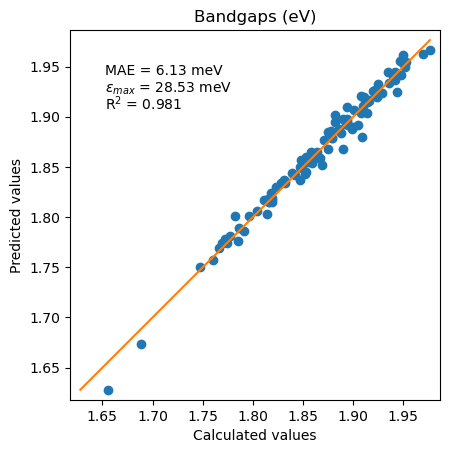

In [15]:
ypred,trash,trash=ensemble_inference(model, Xtest)
mae,maxerr,r2=score_model(ytest,ypred,print_results=True,graph=True,print_ingraph=True)

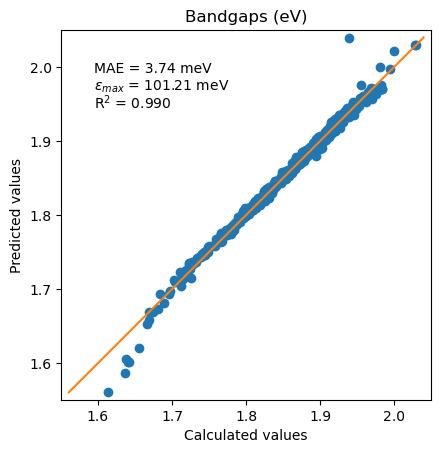

(3.7411790825657536, 101.20529979858705, 0.9900583063446634)

In [16]:
trainpred,trash,trash=ensemble_inference(model, Xtrain)
score_model(ytrain,trainpred,graph=True,print_ingraph=True)

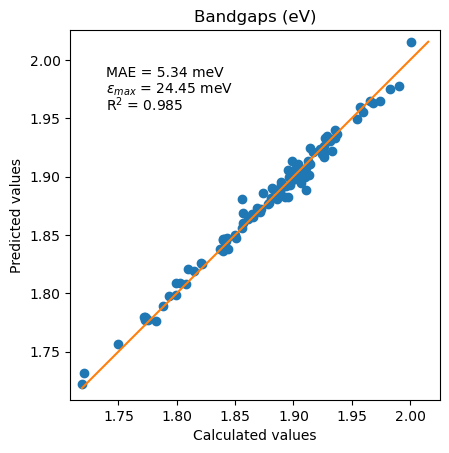

(5.3444781125894645, 24.446175649927238, 0.9854686522023763)

In [17]:
valpred,trash,trash=ensemble_inference(model, Xval)
score_model(yval,valpred,graph=True,print_ingraph=True)

## Running the model recursively in ensembles 

You can train the model in ensembles of variable size and get averages of metrics and predictions.

In [18]:
n=10
if mode=="train":
    for i in range(n):
        model = mlp_deep(dropout_rate=0.1)
        shuffle(Xtrain, ytrain)
        history = train_model(model, i)

Mean absolute error 6.046884989107583 meV
Maximum error 27.38585345510036 meV
R2 = 0.9817000142815556


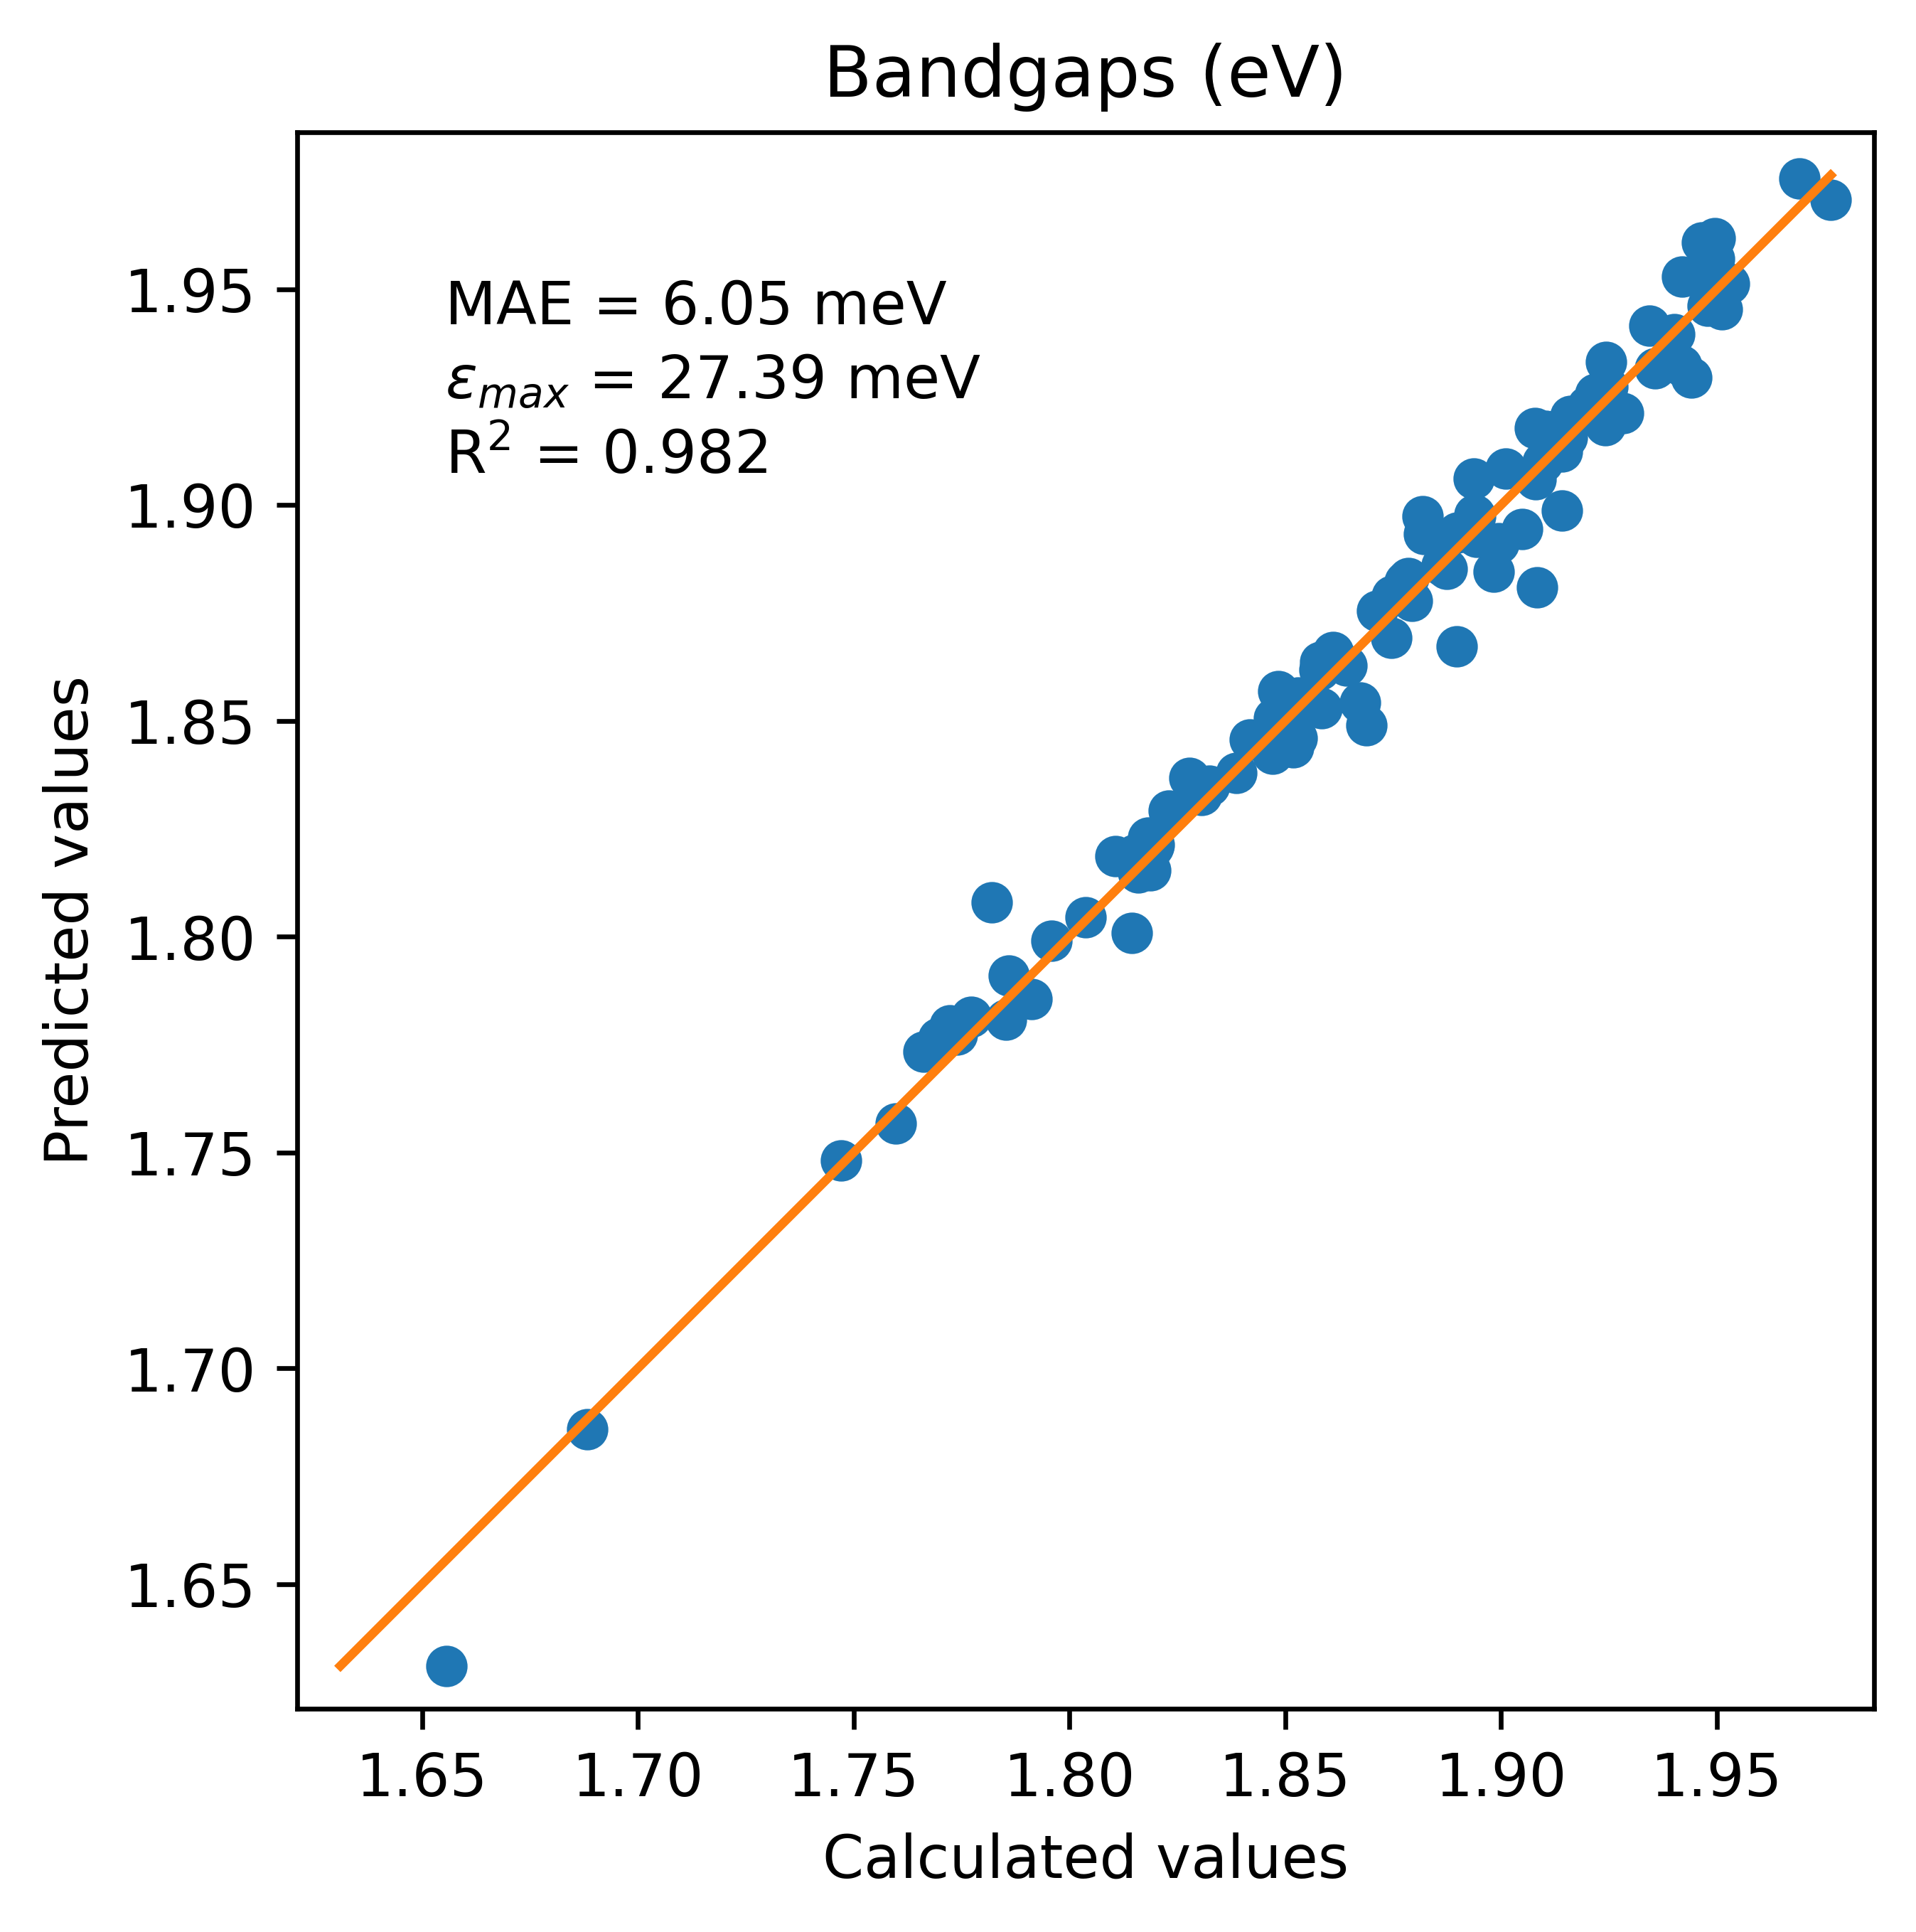

In [19]:
mean_preds,std_preds,preds_ens=ensemble_inference(model, Xtest, 10)
mae_means,maxerr_means,r2_means=score_model(ytest,mean_preds,print_results=True,graph=True,print_ingraph=True,savegraph=True)

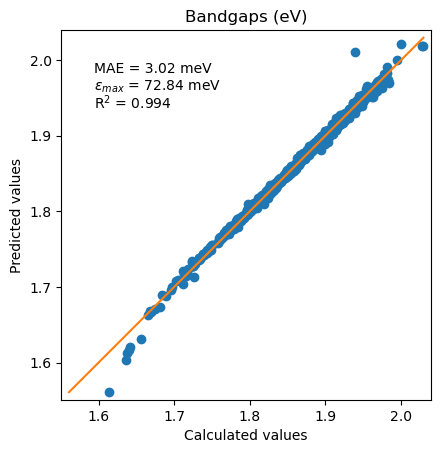

In [20]:
mean_trainpreds,std_trainpreds,trainpreds_ens=ensemble_inference(model, Xtrain, 10)
mae_means,maxerr_means,r2_means=score_model(ytrain,mean_trainpreds,graph=True,print_ingraph=True)

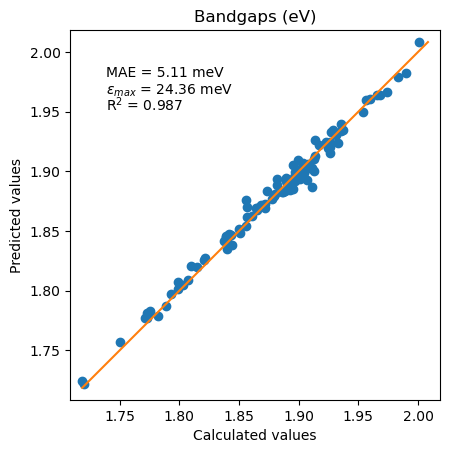

In [21]:
mean_valpreds,std_valpreds,valpreds_ens=ensemble_inference(model, Xval, 10)
mae_means,maxerr_means,r2_means=score_model(yval,mean_valpreds,graph=True,print_ingraph=True)

In [22]:
#Alternative metrics, using means of the metric values instead of means of the predictions
all_mae=[];all_maxerr=[];all_r2=[];
for i in range(n):
    mae,maxerr,r2=score_model(ytest,preds_ens[i,:,:])
    all_mae.append(mae)
    all_maxerr.append(maxerr)
    all_r2.append(r2)
print(np.mean(all_mae))
print(np.mean(all_maxerr))
print(np.mean(all_r2))

6.521902405251572
33.2191205199734
0.9783123199398684


## SHAP Analysis 

In [23]:
feature_labels=["Cluster 1 (k=1,l=0)","Cluster 2 (k=1,l=0)","Cluster 3 (k=2,l=3.130)",
                "Cluster 4 (k=2,l=3.670)","Cluster 5 (k=2,l=3.833)","Cluster 6 (k=2,l=5.421)",
                "Cluster 7 (k=2,l=5.750)","Cluster 8 (k=2,l=6.260)","Cluster 9 (k=2,l=6.260)",
                "Cluster 10 (k=3,l=3.130)","Cluster 11 (k=3,l=3.670)","Cluster 12 (k=3,l=3.670)",
                "Cluster 13 (k=3,l=3.833)","Cluster 14 (k=3,l=5.421)","Cluster 15 (k=3,l=5.421)",
                "Cluster 16 (k=3,l=5.421)","Cluster 17 (k=3,l=5.421)","Cluster 18 (k=3,l=5.750)",
                "Cluster 19 (k=3,l=5.750)","Cluster 20 (k=3,l=5.750)","Cluster 21 (k=3,l=5.750)",
                "Cluster 22 (k=3,l=5.750)","Cluster 23 (k=3,l=6.260)","Cluster 24 (k=3,l=6.260)",
                "Cluster 25 (k=3,l=6.260)","Cluster 26 (k=3,l=6.260)","Cluster 27 (k=3,l=6.260)",
                "Cluster 28 (k=3,l=6.260)","Cluster 29 (k=3,l=6.260)","Cluster 30 (k=3,l=6.260)",
                "Cluster 31 (k=3,l=6.260)","Cluster 32 (k=3,l=6.260)","Cluster 33 (k=3,l=7.257)",
                "Cluster 34 (k=3,l=7.340)"]

In [24]:
explainer = shap.Explainer(model, Xtrain,feature_names=feature_labels)
shap_values = explainer(Xtest)

Permutation explainer: 103it [00:36,  2.47it/s]                         


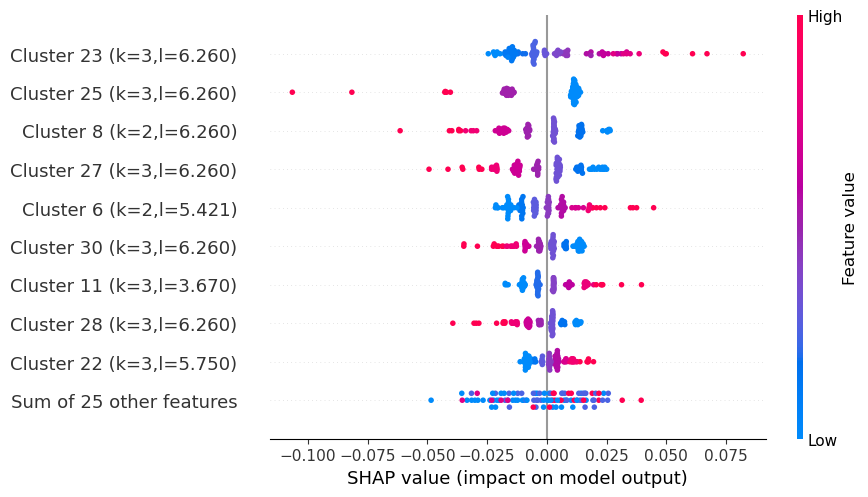

In [25]:
shap.plots.beeswarm(shap_values)

## Model predictions 

Here the previously train model is used to predict the selected feature for all the structures within the space (only for CCF)

In [26]:
#Read input for all the structures
allstr = pd.read_pickle(repodir + '\\descriptors\\correlationmatrix_allstr\\str_corrm.pkl')
Xall=np.stack(allstr["CorrM"].to_numpy())

In [27]:
#Predict property for all the structures and save predictions in the dataframe
mean_allpreds,std_allpreds,allpreds_ens=ensemble_inference(model, Xall, 10)

In [28]:
allstr[feature+'_ens-meanpred']=mean_allpreds
allstr[feature+'_ens-std']=std_allpreds
allstr[feature+'_ens-dev']=abs(mean_allpreds.reshape(len(mean_allpreds),)-np.stack(allstr[feature].to_numpy()))

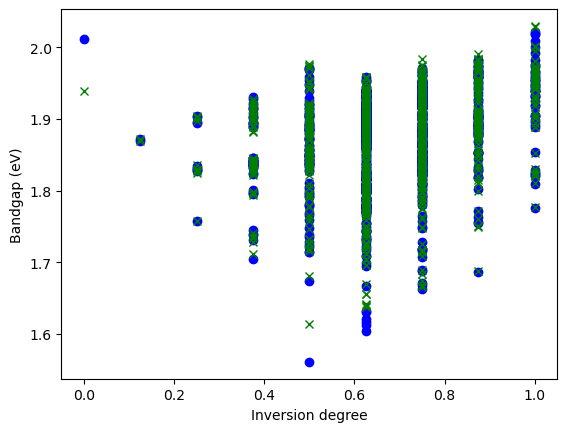

In [29]:
plt.figure()
#plt.plot(allstr['y'],allstr[feature+'_ens-meanpred'],'bo')
plt.plot(allstr[allstr['gga_data']!=False]['y'],allstr[allstr['gga_data']!=False][feature+'_ens-meanpred'],'bo')
#plt.plot(allstr[allstr['gga_data']==False]['y'],allstr[allstr['gga_data']==False][feature+'_ens-meanpred'],'rx')
plt.plot(ener['inv'],ener[feature],'gx')
plt.xlabel("Inversion degree")
plt.ylabel(labelsname+" (eV)")
plt.show()
plt.close()

In [30]:
# Save dataframe with predictions to pickle again.
#allstr.to_pickle(repodir + '\\descriptors\\correlationmatrix_allstr\\'+comp+'str_corrm.pkl')

In [31]:
#Unless the .pkl file is already loaded with Mix Energy predictions from the LR model this code will prompt an error 
plt.figure()
plt.plot(allstr["MixE_pred"],allstr["HSE-corr_ens-meanpred"],'bo')  
plt.xlabel("Mixing energy (eV)")
plt.ylabel("Bandgaps (eV)")
plt.show()
plt.close()

KeyError: 'MixE_pred'

In [ ]:
plt.figure()
for inv in np.unique(allstr['y']):
    plt.plot(allstr[allstr['y']==inv]['MixE_pred'],allstr[allstr['y']==inv]['HSE-corr_ens-meanpred'],'o')
plt.xlabel("Mixing energy (eV)")
plt.ylabel("Bandgap (eV)")
plt.show()
plt.close()